In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def d_t(x, y):
    return 0.5 * (np.linalg.norm(x - y))**2

In [3]:
def epsilon_schedule(t=0): return 0.1 # return 1 / (1 + t)
def alpha_schedule(t=0): return 0.01
def rho_schedule(i=0): return 1.0

In [40]:
def prob_p_kji(N, M):
    p_kji = np.full((N, M, M), 0.2 / (M - 1))  # Default: uniform for k ≠ j

    for i in range(N):
        for j in range(M):
            p_kji[i, j, j] = 0.8  # Set p(k = j | j, i)

    return p_kji

In [41]:
def reinforcement_clustering(beta_min, beta_max, tau, M, X, episodes=100, GD_iter=100, tol = 1e-6):
    N, d = X.shape
    beta = beta_min
    pi = np.full((N, M), 1 / M)
    centroid = np.mean(X, axis=0)
    Y = np.tile(centroid, (M, 1))  # Duplicate the centroid M times
    d_bar = np.zeros((N, M))
    prob = prob_p_kji(N,M)
    t = 0  # time step (used for schedules)

    buffer = np.ones((N,M,M)) # keep memory of interactions

    while beta <= beta_max:
        for _ in range(episodes):  # Outer convergence loop
            i = np.random.randint(N)
            j = np.argmax(pi[i]) # this hould be greedy
            k = np.random.choice(M, p=prob[i,j,:])
            buffer[i,j,k] += 1;  
            eps = epsilon_schedule(t)
            d_bar[i, j] = eps * d_t(X[i], Y[j]) + (1 - eps) * d_t(X[i], Y[k])
        d_mins = np.mean(d_bar, axis = 1, keepdims= True)
        pi = np.exp(-beta * (d_bar - d_mins))
        pi /= pi.sum(axis=1, keepdims=True) # shape (N, M)
        transitipn_prob = buffer / np.sum(buffer, axis = 2, keepdims= True) # shape (N, M, M)
        derivs = np.zeros_like(Y) # shape (M , 2)
        for _ in range(GD_iter):  # Inner convergence loop
            # for l in range(M):
            #     pi_p = np.sum(transitipn_prob[:,:,l] * pi , axis = 1, keepdims= True) 
            #     derivs[l] = np.sum((Y[l] - X) * pi_p, axis= 0)
            pi_p_all = np.sum(transitipn_prob *  pi[:, :, None], axis=1)
            diff = Y[:, None, :] - X[None, :, :]
            derivs = np.sum(diff * pi_p_all.T[:, :, None], axis=1)
            Y = Y - alpha_schedule(t) * derivs
            if np.linalg.norm(derivs) < tol:
                break 
            t += 1  # increment time step
            
        beta *= tau  # annealing

    return pi, Y


In [42]:
# Example synthetic data
X = np.vstack([
    np.random.randn(50, 2) + np.array([2, 2]),
    np.random.randn(50, 2) + np.array([-2, -2])
])

beta_min = 0.01
beta_max = 20.0
tau = 1.1
M = 2  # number of clusters

pi_star, Y_final = reinforcement_clustering(beta_min, beta_max, tau, M, X)

print("Final Centroids (Y):")
print(Y_final)

Final Centroids (Y):
[[ 1.15172892  1.27206309]
 [-0.76706983 -0.76820686]]


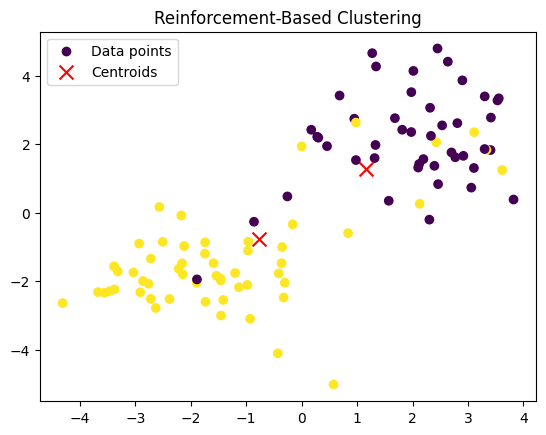

In [43]:
assignments = np.argmax(pi_star, axis=1)

plt.scatter(X[:, 0], X[:, 1], c=assignments, cmap='viridis', label='Data points')
plt.scatter(Y_final[:, 0], Y_final[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title("Reinforcement-Based Clustering")
plt.legend()
plt.show()